In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as nnF
import data_loader
from PIL import Image

/fs/johnston/home/cole/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Import and initialize dataloaders
train_loader, val_loader, test_loader = data_loader.get_dataloader(path="~/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/")

In [3]:
#Create linear classifier
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
    
    def forward(self, x):
        x = nnF.relu(self.fc1(x))
        x = nnF.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [4]:
#Function to append classifier to model
def modify_model(model):
    modified_model = model
    modified_model.fc = MLP()
    return modified_model

In [5]:
#Test on a random tensor
test_model = modify_model(torchvision.models.resnet50())
x=torch.randn(1,3,224,224)
output = test_model(x)
print(output)

tensor([[0.4790]], grad_fn=<SigmoidBackward0>)


In [6]:
#Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
#Define training function
def train(model,optimizer,train_dataloader,val_dataloader,criterion):
    #Set model to training mode
    model.train()
    
    #Initialize loss and accuracy
    train_loss = 0
    train_accuracy = 0
    
    for data in train_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Zero the gradients
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        
        #Backward pass
        loss.backward()
        optimizer.step()
        
        #Calculate loss and accuracy
        train_loss += loss.item()
        train_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader.dataset)
    
    #Initialize loss and accuracy
    val_loss = 0
    val_accuracy = 0
    
    for data in val_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        
        #Calculate loss and accuracy
        val_loss += loss.item()
        val_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader.dataset)
    
    return train_loss, train_accuracy, val_loss, val_accuracy

#### From Scratch

In [8]:
resnet50 = torchvision.models.resnet50()
scratch_model = modify_model(resnet50)
scratch_model.to(device)

optimizer = torch.optim.Adam(scratch_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 50):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(scratch_model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_scratch_model = scratch_model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

epoch 0 training loss: 0.6362991345813498 acc: 0.6468842729970327 val acc: 0.7833333333333333
epoch 1 training loss: 0.41276499652303755 acc: 0.8204747774480712 val acc: 0.7833333333333333
epoch 2 training loss: 0.3402416480239481 acc: 0.8605341246290801 val acc: 0.8333333333333334
epoch 3 training loss: 0.32149901997763664 acc: 0.8664688427299704 val acc: 0.8666666666666667
epoch 4 training loss: 0.3009239842649549 acc: 0.8803165182987142 val acc: 0.8166666666666667
epoch 5 training loss: 0.2840262689278461 acc: 0.8941641938674579 val acc: 0.9
epoch 6 training loss: 0.25263646605890244 acc: 0.8941641938674579 val acc: 0.85
epoch 7 training loss: 0.27364797750487924 acc: 0.8961424332344213 val acc: 0.8833333333333333
epoch 8 training loss: 0.2689521888969466 acc: 0.8956478733926805 val acc: 0.8166666666666667
epoch 9 training loss: 0.25093953660689294 acc: 0.890702274975272 val acc: 0.8833333333333333
epoch 10 training loss: 0.24424400471616536 acc: 0.8956478733926805 val acc: 0.9
epoc

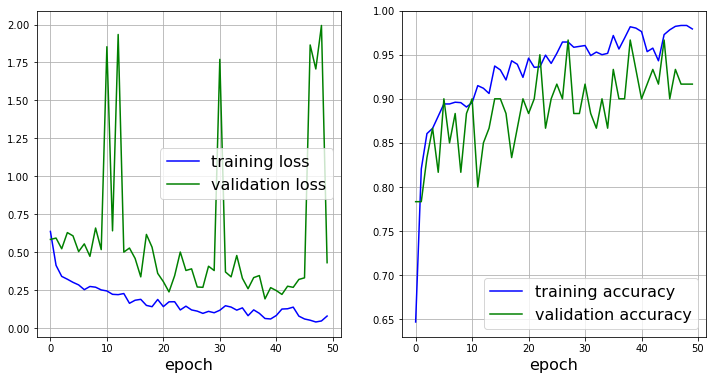

In [9]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [21]:
scratch_model.load_state_dict(best_scratch_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = scratch_model(inputs).flatten()
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.9225


In [11]:
#Save best model for future use
torch.save({'model_state_dict': best_scratch_model},'scratch_model.pt')

In [12]:
# #Load best model if needed
# checkpoint=torch.load('scratch_model.pt')
# scratch_model = modify_model(torchvision.models.resnet50())
# scratch_model.load_state_dict(checkpoint['model_state_dict'])

#### Pretrained Model

In [13]:
pretrained_resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V2')
for param in pretrained_resnet50.parameters():
    param.requires_grad = False
pretrained_model = modify_model(pretrained_resnet50)
pretrained_model.to(device)

optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

best_val = 0
best_model = None

for epoch in range(0, 50):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(pretrained_model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    
    if acc_val > best_val:
        best_val = acc_val
        best_pretrained_model = pretrained_model.state_dict()
        

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train, 'val acc:', acc_val)

epoch 0 training loss: 0.4644924139138311 acc: 0.7818991097922848 val acc: 0.8166666666666667
epoch 1 training loss: 0.2572957390220836 acc: 0.8911968348170128 val acc: 0.8666666666666667
epoch 2 training loss: 0.18656558159273118 acc: 0.9317507418397626 val acc: 0.8666666666666667
epoch 3 training loss: 0.13765364047139883 acc: 0.9446092977250248 val acc: 0.8333333333333334
epoch 4 training loss: 0.10802568384679034 acc: 0.9614243323442137 val acc: 0.85
epoch 5 training loss: 0.06930840889253886 acc: 0.973293768545994 val acc: 0.8666666666666667
epoch 6 training loss: 0.09129371406015707 acc: 0.9643916913946587 val acc: 0.9
epoch 7 training loss: 0.06153386442019837 acc: 0.9762611275964391 val acc: 0.9
epoch 8 training loss: 0.04163854361104313 acc: 0.983679525222552 val acc: 0.8333333333333334
epoch 9 training loss: 0.060513402338983724 acc: 0.9802176063303659 val acc: 0.8666666666666667
epoch 10 training loss: 0.03892750102022546 acc: 0.9851632047477745 val acc: 0.9166666666666666
e

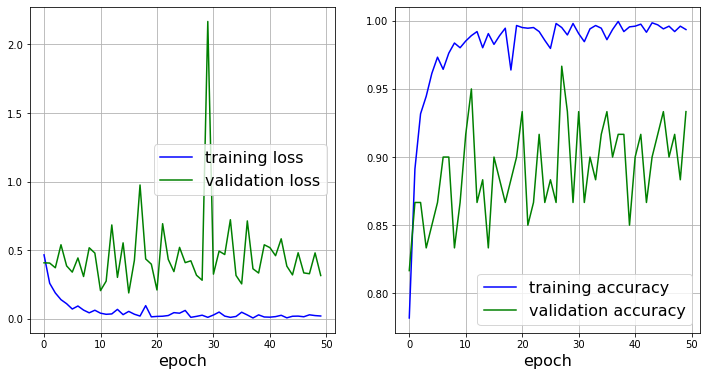

In [14]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [22]:
pretrained_model.load_state_dict(best_pretrained_model)
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = pretrained_model(inputs).flatten()
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.9425


In [16]:
#Save best model for future use
torch.save({'model_state_dict': best_pretrained_model},'pretrained_model.pt')

In [17]:
# #Load best model if needed
# checkpoint=torch.load('pretrained_model.pt')
# pretrained_model = modify_model(torchvision.models.resnet50(weights='IMAGENET1K_V2'))
# pretrained_model.load_state_dict(checkpoint['model_state_dict'])

#### Comparison

It's clear that the eventual performance of both models is quite similar, with the pretrained model slightly outperforming the model trained from scratch. However, the pretrained model converged much faster since there were many less parameters to train. It's difficult to make a sweeping claim about transfer learning given the small amount of data involved in training these complex models, but it is clear that within the scope of this project that transfer learning gave the added benefit of quick training and even boosted performance

### CAM Analysis

In [23]:
from pytorch_grad_cam import EigenCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

#Get test data
test_images = ['NORMAL/Non-Covid (1207).png','NORMAL/Non-Covid (472).png','NORMAL/Non-Covid (1028).png',
               'COVID/Covid (962).png','COVID/Covid (1243).png','COVID/Covid (1078).png']  #Image taken from test set

inputs = torch.zeros((len(test_images),3,224,224))
imgs = []

for i,path in enumerate(test_images):
    path = '/fs/johnston/home/cole/Projects/COVID19-Transfer-Learning/COVID19-Transfer-Learning/Data/'+path
    img = np.array(Image.open(path).convert('RGB'))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    inputs[i] = input_tensor
    imgs.append(img)

#### EigenCAM

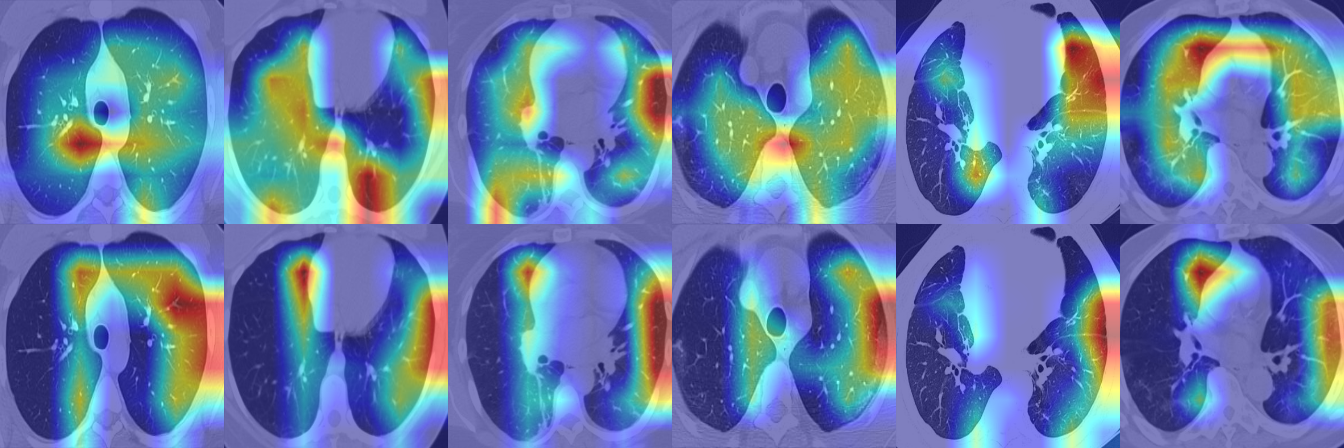

In [24]:
scratch_eigen_cam = EigenCAM(model=scratch_model, target_layers=[scratch_model.layer4[-1]])
pretrained_eigen_cam = EigenCAM(model=pretrained_model, target_layers=[pretrained_model.layer4[-1]])

scratch_grayscale_cams = scratch_eigen_cam(input_tensor=inputs, targets=None)
pretrained_grayscale_cams = pretrained_eigen_cam(input_tensor=inputs, targets=None)

scratch_cam_images = []
pretrained_cam_images = []

for i in range(len(test_images)):
    scratch_cam_images.append(show_cam_on_image(imgs[i], scratch_grayscale_cams[i, :], use_rgb=True))
    pretrained_cam_images.append(show_cam_on_image(imgs[i], pretrained_grayscale_cams[i, :], use_rgb=True))

scratch_output = np.concatenate(scratch_cam_images, axis=1)
pretrained_output = np.concatenate(pretrained_cam_images, axis=1)

output = np.concatenate([scratch_output, pretrained_output], axis=0)

Image.fromarray(output)

#### ScoreCAM

100%|██████████| 128/128 [00:01<00:00, 88.66it/s]


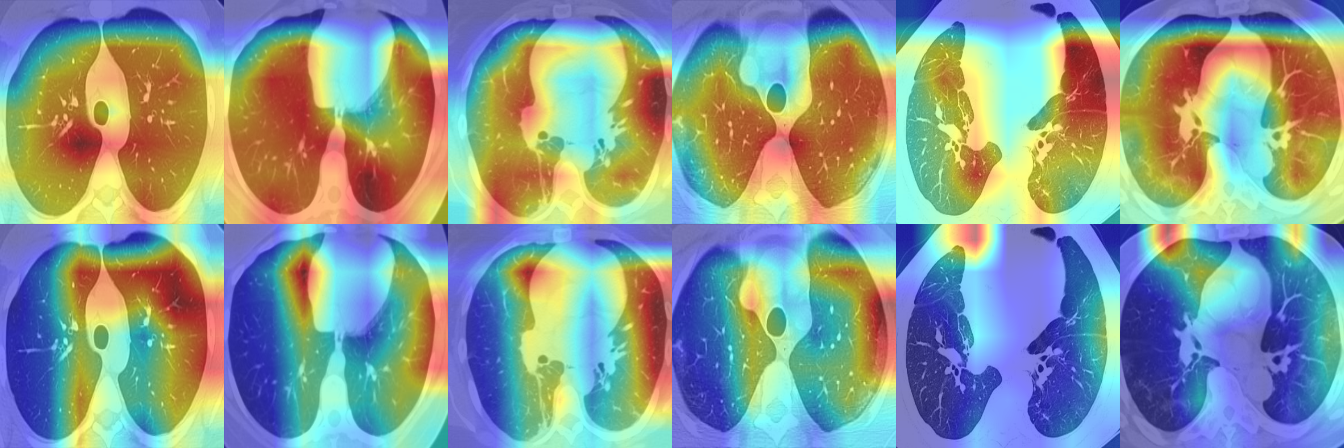

In [25]:
scratch_score_cam = ScoreCAM(model=scratch_model, target_layers=[scratch_model.layer4[-1]])
pretrained_score_cam = ScoreCAM(model=pretrained_model, target_layers=[pretrained_model.layer4[-1]])

scratch_grayscale_cams = scratch_score_cam(input_tensor=inputs, targets=None)
pretrained_grayscale_cams = pretrained_score_cam(input_tensor=inputs, targets=None)

scratch_cam_images = []
pretrained_cam_images = []

for i in range(len(test_images)):
    scratch_cam_images.append(show_cam_on_image(imgs[i], scratch_grayscale_cams[i, :], use_rgb=True))
    pretrained_cam_images.append(show_cam_on_image(imgs[i], pretrained_grayscale_cams[i, :], use_rgb=True))

scratch_output = np.concatenate(scratch_cam_images, axis=1)
pretrained_output = np.concatenate(pretrained_cam_images, axis=1)

output = np.concatenate([scratch_output, pretrained_output], axis=0)

Image.fromarray(output)

It's clear that though the pretrained model outperforms the model trained from scratch, the pretrained model seems to focus on aspects of the data that have little to no medical relevance, while the model trained from scratch focuses much more on the medically relevant portions of the images.